Copyright 2016 The TensorFlow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This notebook lets you run predictions against an image classification model trained with `transfer_learning.py` (and bootstrapping from the saved Inception v3 image classification model), in this same directory. See the README in this directory for more information on running the training on a set of photos first.

First, some imports and definitions:

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import glob
import hashlib
import json
import os
import re
import struct
import sys
import tarfile
import time

import numpy as np
from six.moves import urllib
import tensorflow as tf
from tensorflow.contrib.learn import ModeKeys

from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

import transfer_learning

# If you've already downloaded the inception model, and it's elsewhere, 
# edit this path to reflect that so you don't need to re-download.
INCEPTION_MODEL_DIR = '/Users/aa/Developer/datasets/inception'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

# Tensors to return from the Inception 
BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape:0'
BOTTLENECK_TENSOR_SIZE = 2048
MODEL_INPUT_WIDTH = 299
MODEL_INPUT_HEIGHT = 299
MODEL_INPUT_DEPTH = 3
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'
RESIZED_INPUT_TENSOR_NAME = 'ResizeBilinear:0'

LABELS_FILENAME = "output_labels.json"


**Edit the following** to point to the model directory in which the trained model that you want to use resides.  If you just did a training run, the directory name will have been printed to STDOUT.

In [2]:
# Replace MODEL_DIR with the path to the directory in which your learned model resides.
#MODEL_DIR = '/tmp/tfmodels/img_classify/your-model-dir'
MODEL_DIR = '/tmp/tfmodels/img_classify/1481231561'    # Atul - using the Hugs/No-hugs dataset

Now define some helper functions. You'll find these functions in `transfer_learning.py` also.

(In `run_bottleneck_on_image`, note that we're calling `sess.run()` to get the value of the 'bottleneck' layer of the Inception graph, with image data fed to the JPEG_DATA_TENSOR_NAME node.)

In [3]:
def create_inception_graph():
  """"Creates a graph from saved GraphDef file and returns a Graph object.
  Return:
      graph: graph of the inception model
      bottleneck tensor:
      jpeg tensor:
      resized image tensor:
  """
  with tf.Session() as sess:
    model_filename = os.path.join(
        INCEPTION_MODEL_DIR, 'classify_image_graph_def.pb')
    print('Reading model from:', model_filename)
    
    with gfile.FastGFile(model_filename, 'rb') as f:
      print('Importing graph...')
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
      # read selected tensors from the graph/model
      bottleneck_tensor, jpeg_data_tensor, resized_input_tensor = (
          tf.import_graph_def(graph_def, 
                              name='', 
                              return_elements=[BOTTLENECK_TENSOR_NAME, 
                                               JPEG_DATA_TENSOR_NAME,
                                               RESIZED_INPUT_TENSOR_NAME]))
    
  return sess.graph, bottleneck_tensor, jpeg_data_tensor, resized_input_tensor


def run_bottleneck_on_image(sess, 
                            image_data, 
                            image_data_tensor,
                            bottleneck_tensor):
  """Runs inference on an image to extract the 'bottleneck' summary layer.
  """
  bottleneck_values = sess.run(bottleneck_tensor,
                               {image_data_tensor: image_data})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values

Next, we need to load the file that gives us the class name ordering used for the result vectors during training. (Since this info was generated from reading the photos directories structure, the ordering can potentially change.  We need to make sure that doesn't happen, so that we interpret the prediction results consistently).

In [5]:
# load the labels list, needed to create the model; if it's 
# not there, we can't proceed
output_labels_file = os.path.join(MODEL_DIR, "output_labels.json")
print('Looking for file:', output_labels_file)
if gfile.Exists(output_labels_file):
  with open(output_labels_file, 'r') as lfile:
    labels_string = lfile.read()
    labels_list   = json.loads(labels_string)
    print("labels list: %s" % labels_list)
    class_count   = len(labels_list)
else:
  print("Labels list %s not found; we can't proceed." % output_labels_file)


Looking for file: /tmp/tfmodels/img_classify/1481231561/output_labels.json
labels list: ['not hugs', 'hugs']


Define a function to run the image predictions. First, we need to get the 'bottleneck' values, using the graph loaded from the Inception model. Then, we feed that data to our own trained model.
`classifier` is a custom Estimator, and we will use its `predict` method. (We'll define the Estimator in a few more cells). 

In [6]:
def make_image_predictions(classifier, 
                           jpeg_data_tensor, 
                           bottleneck_tensor, 
                           path_list, 
                           labels_list):
  """Use the learned model to make predictions."""

  if not labels_list:
    output_labels_file = os.path.join(MODEL_DIR, LABELS_FILENAME)
    if gfile.Exists(output_labels_file):
      with open(output_labels_file, 'r') as lfile:
        labels_string = lfile.read()
        labels_list = json.loads(labels_string)
        print("labels list: %s" % labels_list)
    else:
      print("Labels list %s not found" % output_labels_file)
      return None

  sess = tf.Session()
  bottlenecks = []
  print("Predicting for images: %s" % path_list)
  for img_path in path_list:
    # get bottleneck for an image path.
    if not gfile.Exists(img_path):
      tf.logging.fatal('File does not exist %s', img_path)
    image_data = gfile.FastGFile(img_path, 'rb').read()
    bottleneck_values = run_bottleneck_on_image(sess, image_data,
                                                jpeg_data_tensor,
                                                bottleneck_tensor)
    bottlenecks.append(bottleneck_values)
  prediction_input = np.array(bottlenecks)
  predictions = classifier.predict(x=prediction_input, as_iterable=True)
  print("Predictions:")
  for _, p in enumerate(predictions):
    print("---------")
    for k in p.keys():
      print("%s is: %s " % (k, p[k]))
      if k == "index":
        print("index label is: %s" % labels_list[p[k]])

Define the Inception-based graph we'll use to generate the 'bottleneck' values. Wait for this to print "Finished" before continuing.

In [7]:
# Set up the pre-trained graph 
transfer_learning.maybe_download_and_extract(INCEPTION_MODEL_DIR)

# get the pre-ptained Graph, Bottleneck tensor, Jpeg data tensor, Resized image tensor
graph, bottleneck_tensor, jpeg_data_tensor, resized_image_tensor = (create_inception_graph())
print("Finished.")

Looking for file: /Users/aa/Developer/datasets/inception/inception-2015-12-05.tgz
Reading model from: /Users/aa/Developer/datasets/inception/classify_image_graph_def.pb
Importing graph...
Finished.


Define our custom Estimator. (As the lab exercise, you will write some of the code that does this).

In [8]:
# Define the custom estimator
model_fn = transfer_learning.make_model_fn(class_count, 'final_result')
model_params = {}
classifier = tf.contrib.learn.Estimator(model_fn=model_fn, 
                                        params=model_params, 
                                        model_dir=MODEL_DIR)

INFO:tensorflow:Using config: {'keep_checkpoint_every_n_hours': 10000, 'master': '', 'evaluation_master': '', '_job_name': None, 'keep_checkpoint_max': 5, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'save_summary_steps': 100, 'task': 0, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, 'cluster_spec': None, '_is_chief': True}


In [9]:
img_list = transfer_learning.get_prediction_images('prediction_images')

Looking for images in 'prediction_images'


For fun, display the images that we're going to predict the classification for.

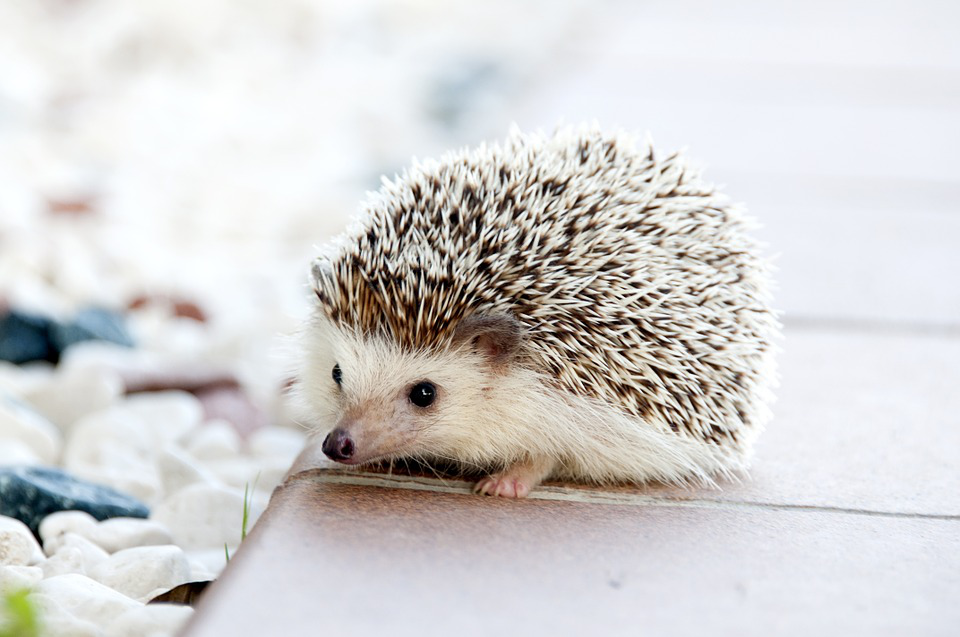

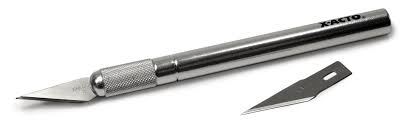

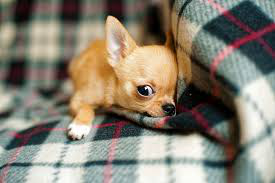

In [10]:
# If PIL/Pillow is not installed, this step is not important
import PIL.Image
from IPython.display import display
for imgfile in img_list:
    img = PIL.Image.open(imgfile)
    display(img)
    

Run the predict() method of our Estimator to predict the classifications of our list of images.

In [11]:
make_image_predictions(classifier, 
                       jpeg_data_tensor, 
                       bottleneck_tensor, 
                       img_list, 
                       labels_list)

Predicting for images: ['prediction_images/hedgehog.jpg', 'prediction_images/knife.jpg', 'prediction_images/puppy.jpg']


INFO:tensorflow:Loading model from checkpoint: /tmp/tfmodels/img_classify/1481231561/model.ckpt-15000-?????-of-00001.


Predictions:
---------
index is: 0 
index label is: not hugs
class_vector is: [ 0.99830794  0.00169209] 
---------
index is: 0 
index label is: not hugs
class_vector is: [  9.99726713e-01   2.73331563e-04] 
---------
index is: 1 
index label is: hugs
class_vector is: [ 0.25867724  0.74132276] 


With the default images, you should see that the hedgehog and knife are not judged very huggable, but the puppy is!